In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cvxopt
import cvxopt.solvers
# Math
import numpy as np
from numpy import linalg
#Scikit
from sklearn.svm import SVC
# Custom Code:
import plotting
import datageneration

In [7]:
cvxopt.solvers.options['show_progress'] = False

class SVM():
	def __init__(self,kernel="rbf",polyconst=1,gamma=10,degree=2):
		self.kernel = kernel
		self.polyconst = float(1)
		self.gamma = float(gamma)
		self.degree = degree
		self.kf = {
			"linear":self.linear,
			"rbf":self.rbf,
			"poly":self.polynomial
		}
		self._support_vectors = None
		self._alphas = None
		self.intercept = None
		self._n_support = None
		self.weights = None
		self._support_labels = None
		self._indices = None

	def linear(self,x,y):
		return np.dot(x.T,y)

	def polynomial(self,x,y):
		return (np.dot(x.T,y) + self.polyconst)**self.degree #polycont is C

	def rbf(self,x,y):
		return np.exp(-1.0*self.gamma*np.dot(np.subtract(x,y).T,np.subtract(x,y)))

	def transform(self,X):
		K = np.zeros([X.shape[0],X.shape[0]])
		for i in range(X.shape[0]):
			for j in range(X.shape[0]):
				K[i,j] = self.kf[self.kernel](X[i],X[j])
		return K

	def fit(self,data,labels):
            num_data,num_features = data.shape
            labels = labels.astype(np.double)
            K = self.transform(data)
            P = cvxopt.matrix(np.outer(labels,labels)*K)
            q = cvxopt.matrix(np.ones(num_data)*-1)
            A = cvxopt.matrix(labels,(1,num_data))
            b = cvxopt.matrix(0.0)
            G = cvxopt.matrix(np.diag(np.ones(num_data) * -1))
            h = cvxopt.matrix(np.zeros(num_data))
            
            alphas = np.ravel(cvxopt.solvers.qp(P, q, G, h, A, b)['x'])


            is_sv = alphas>1e-5 # this must >=0
            self._support_vectors = data[is_sv]
            self._n_support = np.sum(is_sv)
            self._alphas = alphas[is_sv]
            self._support_labels = labels[is_sv]
            self._indices = np.arange(num_data)[is_sv]
            self.intercept = 0
            for i in range(self._alphas.shape[0]):
                self.intercept += self._support_labels[i] #here interecept means bias 
                self.intercept -= np.sum(self._alphas*self._support_labels*K[self._indices[i],is_sv])
            self.intercept /= self._alphas.shape[0] #normalize
            self.weights = np.sum(data*labels.reshape(num_data,1)*self._alphas.reshape(num_data,1),axis=0,keepdims=True) if self.kernel == "linear" else None

	def signum(self,X):
		return np.where(X>0,1,-1)

	def project(self,X):
		if self.kernel=="linear":
			score = np.dot(X,self.weights)+self.intercept
		else:
			score = np.zeros(X.shape[0])
			for i in range(X.shape[0]):
				s = 0
				for alpha,label,sv in zip(self._alphas,self._support_labels,self._support_vectors):
					s += alpha*label*self.kf[self.kernel](X[i],sv) #decision method
				score[i] = s
			score = score + self.intercept
		return score

	def predict(self,X):
		return self.signum(self.project(X))



Max-class classifier training set accuracy:  80.66666666666666 %
SVM model Training set accuracy:  100.0 %
Number of SVMs computed:  24
Value of intercept:  -4.391291916793956


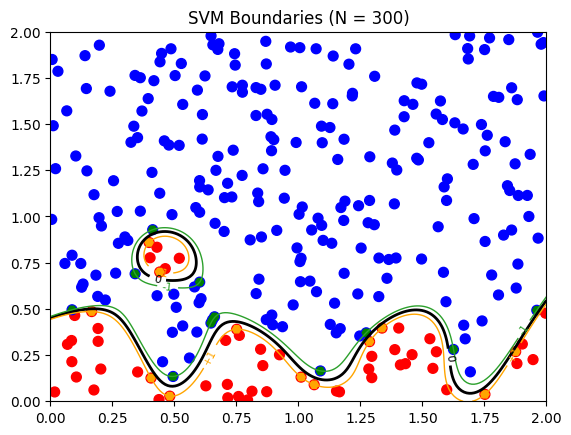

In [13]:

np.random.seed(2)

def get_data(lower,upper,num,num_dims):
	return np.random.uniform(lower,upper,size=(num,num_dims))

def get_labels(X):
	Y = []
	for x1,x2 in X:
		if x2 < np.sin(10*x1)/5 + 0.3 or ((x2 - 0.8)**2 + (x1 - 0.5)**2)<0.15**2:
			Y.append(1)
		else:
			Y.append(-1)
	return np.asarray(Y)

def main():
	N = 300
	data = get_data(0,2,N,2) 
	labels = get_labels(data).reshape(-1)
	predictions = np.ones_like(labels)*-1
	print("Max-class classifier training set accuracy: ",np.mean(np.equal(predictions,labels))*100,"%")
	model = SVM(kernel="rbf",gamma=3)
	model.fit(data,labels)
	predictions = model.predict(data)
	print("SVM model Training set accuracy: ",np.mean(np.equal(predictions,labels))*100,"%")
	print("Number of SVMs computed: ",model._n_support)
	print("Value of intercept: ",model.intercept)
	# print(model.project(data))

	color = np.where(model._support_labels==1,"orange","green")
	plt.scatter(data[:, 0], data[:, 1], c=labels, s=50, cmap=plt.cm.bwr)
	plt.scatter(model._support_vectors[:, 0], model._support_vectors[:, 1], s=35, c=color, marker='H')
	plt.title('SVM Boundaries (N = %d)' % (N))

	X1, X2 = np.meshgrid(np.linspace(0, 2, 200), np.linspace(0, 2, 200))
	X_T = np.array([[x1, x2] for x1, x2 in zip(np.ravel(X1), np.ravel(X2))])

	Z = model.project(X_T).reshape(X1.shape)

	H = plt.contour(X1, X2, Z, [0.0], colors='k', linewidths=2, origin='lower')
	H_1= plt.contour(X1, X2, Z + 1, [0.0],colors='tab:green', linewidths=1, origin='lower')
	H1 = plt.contour(X1, X2, Z - 1, [0.0], colors='orange', linewidths=1, origin='lower')

	plt.clabel(H,inline=True, fmt="0", fontsize=8)
	plt.clabel(H_1,inline=True, fmt="-1", fontsize=8)
	plt.clabel(H1,inline=True, fmt="+1", fontsize=8)
	plt.axis("tight")
	plt.show()
	
if __name__ == '__main__':
	main()

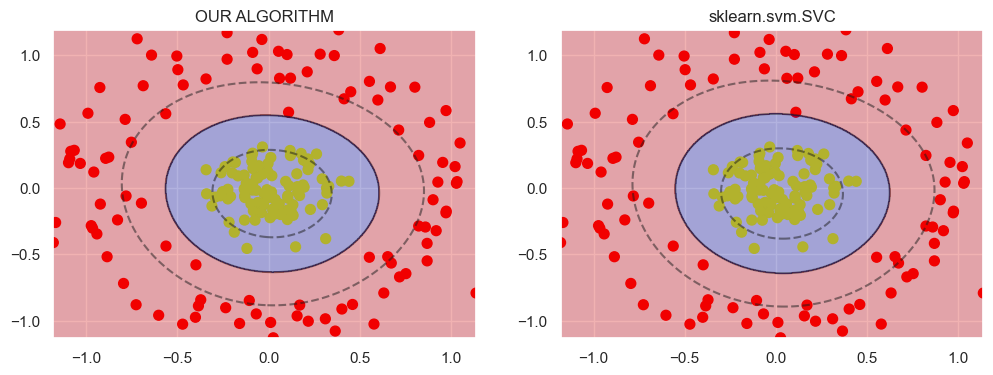

In [159]:
import numpy as np

class SVM:
  def __init__(self, kernel='linear', C=10000.0, max_iter=100000, degree=3, gamma=1):
    self.kernel = {'poly'  : lambda x,y: np.dot(x, y.T)**degree,
                   'rbf'   : lambda x,y: np.exp(-gamma*np.sum((y - x[:,np.newaxis])**2, axis=-1)),
                   'linear': lambda x,y: np.dot(x, y.T)}[kernel]
    self.C = C
    self.max_iter = max_iter

  def restrict_to_square(self, t, v0, u):
    t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
    return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]

  def fit(self, X, y):
    self.X = X.copy()
    self.y = y * 2 - 1
    self.lambdas = np.zeros_like(self.y, dtype=float)
    self.K = self.kernel(self.X, self.X) * self.y[:,np.newaxis] * self.y
    
    for _ in range(self.max_iter):
      for idxM in range(len(self.lambdas)):
        idxL = np.random.randint(0, len(self.lambdas))
        Q = self.K[[[idxM, idxM], [idxL, idxL]], [[idxM, idxL], [idxM, idxL]]]
        v0 = self.lambdas[[idxM, idxL]]
        k0 = 1 - np.sum(self.lambdas * self.K[[idxM, idxL]], axis=1)
        u = np.array([-self.y[idxL], self.y[idxM]])
        t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15)
        self.lambdas[[idxM, idxL]] = v0 + u * self.restrict_to_square(t_max, v0, u)
    
    idx, = np.nonzero(self.lambdas > 1E-15)
    self.b = np.mean((1.0 - np.sum(self.K[idx] * self.lambdas, axis=1)) * self.y[idx])
  
  def decision_function(self, X):
    return np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis=1) + self.b

  def predict(self, X):
    return (np.sign(self.decision_function(X)) + 1) // 2

######### TESTS ############
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs, make_circles
from matplotlib.colors import ListedColormap

def test_plot(X, y, svm_model, axes, title):
  plt.axes(axes)
  xlim = [np.min(X[:, 0]), np.max(X[:, 0])]
  ylim = [np.min(X[:, 1]), np.max(X[:, 1])]
  xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
  rgb=np.array([[210, 0, 0], [0, 0, 150]])/255.0
  
  svm_model.fit(X, y)
  z_model = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
  
  plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
  plt.contour(xx, yy, z_model, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
  plt.contourf(xx, yy, np.sign(z_model.reshape(xx.shape)), alpha=0.3, levels=2, cmap=ListedColormap(rgb), zorder=1)
  plt.title(title)

X, y = make_circles(200, factor=.1, noise=.15)




fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
test_plot(X, y, SVM(kernel='rbf', C=1, max_iter=60, gamma=1), axs[0], 'OUR ALGORITHM')
test_plot(X, y, SVC(kernel='rbf', C=1, gamma=1), axs[1], 'sklearn.svm.SVC')

# X, y = make_blobs(n_samples=50, centers=2, random_state=0, cluster_std=1.4)
# fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
# test_plot(X, y, SVM(kernel='linear', C=10, max_iter=60), axs[0], 'OUR ALGORITHM')
# test_plot(X, y, SVC(kernel='linear', C=10), axs[1], 'sklearn.svm.SVC')

# fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
# test_plot(X, y, SVM(kernel='poly', C=5, max_iter=60, degree=3), axs[0], 'OUR ALGORITHM')
# test_plot(X, y, SVC(kernel='poly', C=5, degree=3), axs[1], 'sklearn.svm.SVC')

sklearn:


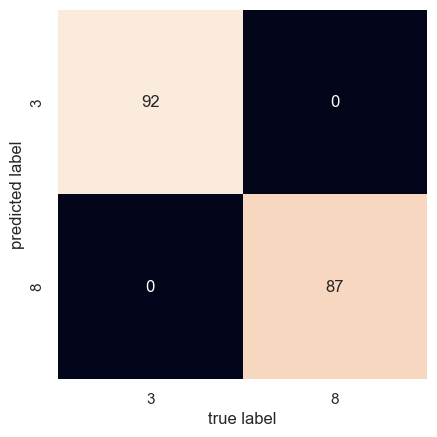

custom svm:


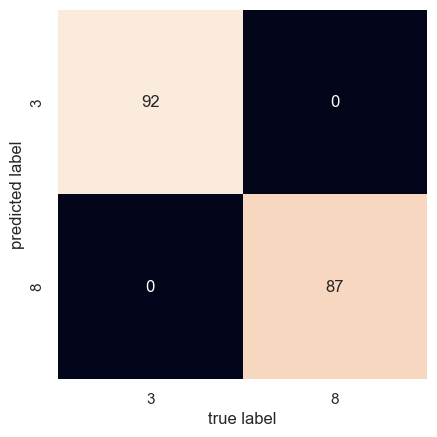

In [148]:
###### TESTS WITH MNIST ###########

from sklearn import datasets, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_A = 3
class_B = 8

digits = datasets.load_digits()
mask = (digits.target == class_A) | (digits.target == class_B)
data = digits.images.reshape((len(digits.images), -1))[mask]
target = digits.target[mask] // max([class_A, class_B]) # rescale to 0,1
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.5, shuffle=True)

def plot_confusion(clf):
  clf.fit(X_train, y_train)
  y_fit = clf.predict(X_test)

  mat = confusion_matrix(y_test, y_fit)
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=[class_A,class_B], yticklabels=[class_A,class_B])
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  plt.show()

print('sklearn:')
plot_confusion(svm.SVC(C=1.0, kernel='rbf', gamma=0.001))
print('custom svm:')
plot_confusion(SVM(kernel='rbf', C=1.0, max_iter=60, gamma=0.001))

In [149]:
import numpy as np
 
def gaussian_kernel_matrix(X, sigma):
    distances = np.sum((X[:, np.newaxis] - X) ** 2, axis=-1)
    kernel_matrix = np.exp(-distances / (2 * sigma ** 2))
 
    return kernel_matrix

In [150]:
X = np.array([[1, 2], [3, 4], [5, 6]])
sigma = 1.0
kernel_matrix = gaussian_kernel_matrix(X, sigma)
print(kernel_matrix)


[[1.00000000e+00 1.83156389e-02 1.12535175e-07]
 [1.83156389e-02 1.00000000e+00 1.83156389e-02]
 [1.12535175e-07 1.83156389e-02 1.00000000e+00]]


In [ ]:
hXX = np.apply_along_axis(lambda x1 : np.apply_along_axis(lambda x2:  self.kernel(x1, x2), 1, X),1, X)
                            